In [10]:
import jax.numpy as jnp
import jax

from tests.test_bidiag_JVP_and_VJP_jax import bidiagonalize_vjpable


In [11]:
!pip install matplotlib

/opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


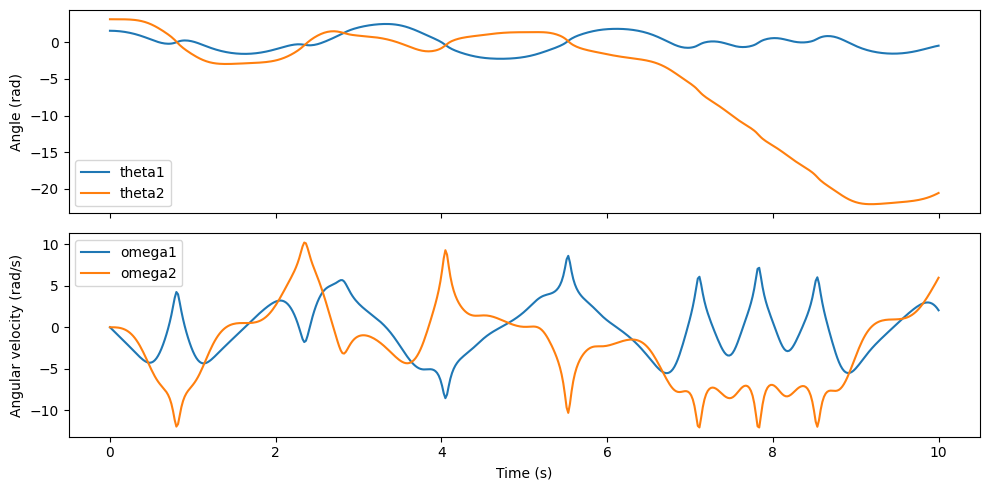

In [ ]:
import jax
import jax.numpy as jnp
from jax import jit
from jax.experimental.ode import odeint


def double_pendulum_rhs(state, t, params):
    """
    Computes the derivatives for the double pendulum system.

    Parameters:
    - state: [theta1, omega1, theta2, omega2]
    - t: time (unused, but required by odeint interface)
    - params: (m1, m2, l1, l2, g)

    Returns:
    - Derivatives: [dtheta1/dt, domega1/dt, dtheta2/dt, domega2/dt]
    """
    theta1, omega1, theta2, omega2 = state
    m1, m2, l1, l2, g = params

    delta = theta2 - theta1
    den1 = (m1 + m2) * l1 - m2 * l1 * jnp.cos(delta) ** 2
    den2 = (l2 / l1) * den1

    dtheta1_dt = omega1
    dtheta2_dt = omega2

    domega1_dt = (
        m2 * l1 * omega1**2 * jnp.sin(delta) * jnp.cos(delta)
        + m2 * g * jnp.sin(theta2) * jnp.cos(delta)
        + m2 * l2 * omega2**2 * jnp.sin(delta)
        - (m1 + m2) * g * jnp.sin(theta1)
    ) / den1

    domega2_dt = (
        -m2 * l2 * omega2**2 * jnp.sin(delta) * jnp.cos(delta)
        + (m1 + m2) * g * jnp.sin(theta1) * jnp.cos(delta)
        - (m1 + m2) * l1 * omega1**2 * jnp.sin(delta)
        - (m1 + m2) * g * jnp.sin(theta2)
    ) / den2

    return jnp.array([dtheta1_dt, domega1_dt, dtheta2_dt, domega2_dt])


@jit
def simulate_double_pendulum(initial_state, t, params):
    """
    Simulate the double pendulum over time.

    Parameters:
    - initial_state: initial [theta1, omega1, theta2, omega2]
    - t: time vector
    - params: (m1, m2, l1, l2, g)

    Returns:
    - state trajectories over time
    """
    return odeint(double_pendulum_rhs, initial_state, t, params)


# Parameters and simulation
params = (1.0, 1.0, 1.0, 1.0, 9.81)  # masses, lengths, gravity
initial_state = jnp.array([jnp.pi / 2, 0.0, jnp.pi, 0.0])
t = jnp.linspace(0.0, 10.0, 500)

trajectory = simulate_double_pendulum(initial_state, t, params)

import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
axs[0].plot(np.asarray(t), np.asarray(trajectory[:, 0]), label="theta1")
axs[0].plot(np.asarray(t), np.asarray(trajectory[:, 2]), label="theta2")
axs[0].set_ylabel("Angle (rad)")
axs[0].legend()

axs[1].plot(np.asarray(t), np.asarray(trajectory[:, 1]), label="omega1")
axs[1].plot(np.asarray(t), np.asarray(trajectory[:, 3]), label="omega2")
axs[1].set_xlabel("Time (s)")
axs[1].set_ylabel("Angular velocity (rad/s)")
axs[1].legend()

plt.tight_layout()
plt.show()


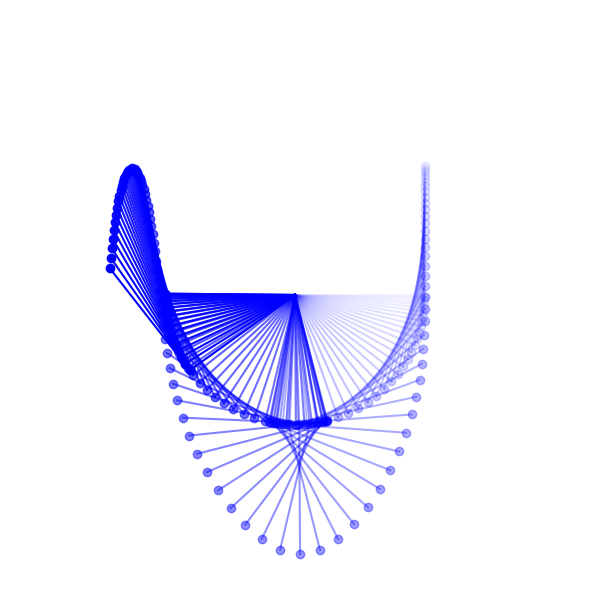

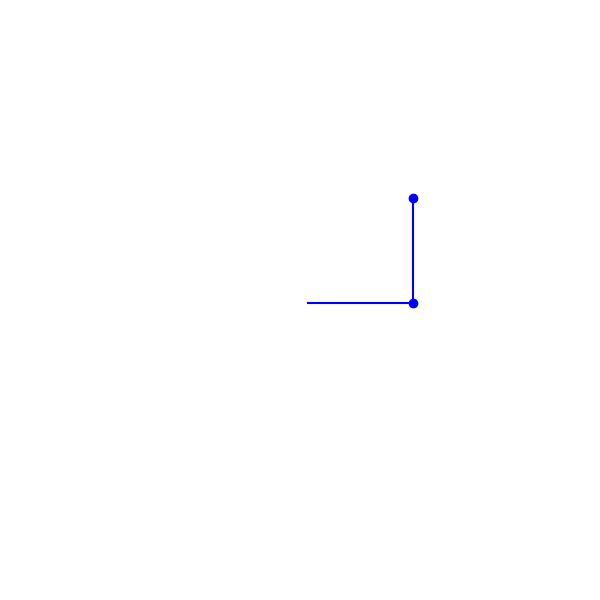

In [ ]:
import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint
import matplotlib.pyplot as plt
import matplotlib.animation as animation


def draw_double_pendulum(ax, state, l1=1.0, l2=1.0, alpha=1.0, color="blue"):
    theta1, _, theta2, _ = state
    x1 = l1 * jnp.sin(theta1)
    y1 = -l1 * jnp.cos(theta1)
    x2 = x1 + l2 * jnp.sin(theta2)
    y2 = y1 - l2 * jnp.cos(theta2)

    ax.plot([0, x1], [0, y1], color=color, alpha=alpha)
    ax.plot([x1, x2], [y1, y2], color=color, alpha=alpha)
    ax.plot(x1, y1, "o", color=color, alpha=alpha)
    ax.plot(x2, y2, "o", color=color, alpha=alpha)


def create_animation(trajectory, l1=1.0, l2=1.0, duration=10):
    """Creates an animation of a double pendulum system.

    Args:
        trajectory: Array of shape (n_steps, 4) containing the state vectors
            [theta1, omega1, theta2, omega2] at each timestep
        l1: Length of the first pendulum rod (default: 1.0)
        l2: Length of the second pendulum rod (default: 1.0)
        duration: Total duration of animation in seconds (default: 10)

    Returns:
        anim: matplotlib.animation.FuncAnimation object
        fig: matplotlib figure object
    """
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_aspect("equal")
    ax.set_xlim(-2.2, 2.2)
    ax.set_ylim(-2.2, 2.2)
    ax.axis("off")

    (line1,) = ax.plot([], [], "b-")
    (line2,) = ax.plot([], [], "b-")
    (point1,) = ax.plot([], [], "bo")
    (point2,) = ax.plot([], [], "bo")

    def init():
        line1.set_data([], [])
        line2.set_data([], [])
        point1.set_data([], [])
        point2.set_data([], [])
        return line1, line2, point1, point2

    def animate(i):
        state = trajectory[i]
        theta1, _, theta2, _ = state

        x1 = l1 * jnp.sin(theta1)
        y1 = -l1 * jnp.cos(theta1)
        x2 = x1 + l2 * jnp.sin(theta2)
        y2 = y1 - l2 * jnp.cos(theta2)

        line1.set_data([0, x1], [0, y1])
        line2.set_data([x1, x2], [y1, y2])
        point1.set_data([x1], [y1])
        point2.set_data([x2], [y2])

        return line1, line2, point1, point2

    anim = animation.FuncAnimation(
        fig,
        animate,
        init_func=init,
        frames=len(trajectory),
        interval=duration * 1000 / len(trajectory),
        blit=True,
    )
    return anim, fig


# Simulation parameters
params = (1.0, 1.0, 1.0, 1.0, 9.81)
initial_state = jnp.array([jnp.pi / 2, 0.0, jnp.pi, 0.0])

seconds = 5

t = jnp.linspace(0.0, float(seconds), 100)
trajectory = simulate_double_pendulum(initial_state, t, params)

# Static visualization
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect("equal")
ax.set_xlim(-2.2, 2.2)
ax.set_ylim(-2.2, 2.2)
ax.axis("off")

for i, state in enumerate(trajectory):
    alpha = (i + 1) / len(trajectory)
    draw_double_pendulum(ax, state, alpha=alpha)

plt.tight_layout()
plt.show()

# Create animation and save as GIF
anim, fig = create_animation(trajectory, duration=seconds)
anim.save("double_pendulum.gif", writer="pillow")
plt.close(fig)

# Display the saved GIF
from IPython.display import Image

Image("double_pendulum.gif")
